**Кредитный скоринг** является важной банковской задачей. 

Стандартный подход заключается в построении классических моделей машинного обучения, таких как логистическая регрессия и градиентный бустинг на табличных данных, в том числе с использованием *агрегирования* из некоторых последовательных данных, таких как истории транзакций клиентов. 


### Описание полей:
- id - identifier of the application
- <span style = 'color : red'> **flag** </span> - target (целевая переменная)
- pre_since_opened - days from credit opening date to data collection date
- pre_since_confirmed - days from credit information confirmation date till data collection date
- pre_pterm - planned number of days from credit opening date to closing date
- pre_fterm - actual number of days from credit opening date to closing date
- pre_till_pclose - planned number of days from data collection date until loan closing date
- pre_till_fclose - actual number of days from data collection date until loan closing date
- pre_loans_credit_limit - credit limit
- pre_loans_next_pay_summ - amount of the next loan payment
- pre_loans_outstanding - outstanding loan amount
- pre_loans_total_overdue - current overdue amount
- pre_loans_max_overdue_sum - maximum overdue amount
- pre_loans_credit_cost_rate - total cost of credit
- pre_loans5 - number of delinquencies of up to 5 days
- pre_loans530 - number of delinquencies from 5 to 30 days
- pre_loans3060 - number of delinquencies from 30 to 60 days
- pre_loans6090 - number of delinquencies from 60 to 90 days
- pre_loans90 - number of delinquencies of more than 90 days
- is_zero_loans_5 - flag: no delinquencies of up to 5 days
- is_zero_loans_530 - flag: no delinquencies of 5 to 30 days
- is_zero_loans_3060 - flag: no delinquencies of 30 to 60 days
- is_zero_loans_6090 - flag: no delinquencies of 60 to 90 days
- is_zero_loans90 - flag: no delinquencies of more than 90 days
- pre_util - ratio of outstanding loan amount to credit limit
- pre_over2limit - ratio of currently overdue debt to credit limit
- pre_maxover2limit - ratio of maximum overdue debt to credit limit
- is_zero_util - flag: ratio of outstanding loan amount to credit limit equals 0
- is_zero_over2limit - flag: ratio of current overdue debt to credit limit equals 0
- is_zero_maxover2limit - flag: ratio of maximum overdue debt to credit limit equals 0
- **<span style = 'color : blue'> enc_paym_{0…n} </span>** - monthly payment statuses of the last n months
- enc_loans_account_holder_type - type of relation to the loan
- enc_loans_credit_status - credit status
- enc_loans_account_cur - currency of the loan
- enc_loans_credit_type - credit type
- pclose_flag - flag: planned number of days from opening date to closing date of the loan
- fclose_flag - flag: actual number of days from credit opening date to closing date undefined

# Open files

In [1]:
# Importing needed libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import gc
import xgboost
from sklearn.linear_model import LogisticRegression
import pickle
from pathlib import Path


In [ ]:
# Define the path to the data directory relative to the notebook's location
data_dir = Path.cwd().parent / 'data'

# Load parquet files
df_train = pd.read_parquet(data_dir / 'train.pq')
df_test = pd.read_parquet(data_dir / 'test.pq')

# Initial data review
print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)
print("\nTarget value 'flag' in train set:")
print(df_train['flag'].value_counts(normalize=True))


Train shape: (175000, 61)
Test shape: (75000, 60)

Target value 'flag' in train set:
flag
0    0.968994
1    0.031006
Name: proportion, dtype: float64


# Handling null values

In [3]:
df_train.isnull().sum().sort_values(ascending=False).head(10)

id                         0
flag                       0
pre_since_opened           0
pre_since_confirmed        0
pre_pterm                  0
pre_fterm                  0
pre_till_pclose            0
pre_till_fclose            0
pre_loans_credit_limit     0
pre_loans_next_pay_summ    0
dtype: int64

In [4]:
df_train.rename(columns={'flag':'target'}, inplace=True)

In [5]:
df_train.duplicated().sum(), df_test.duplicated().sum()

(np.int64(0), np.int64(0))

# Droping correlated columns

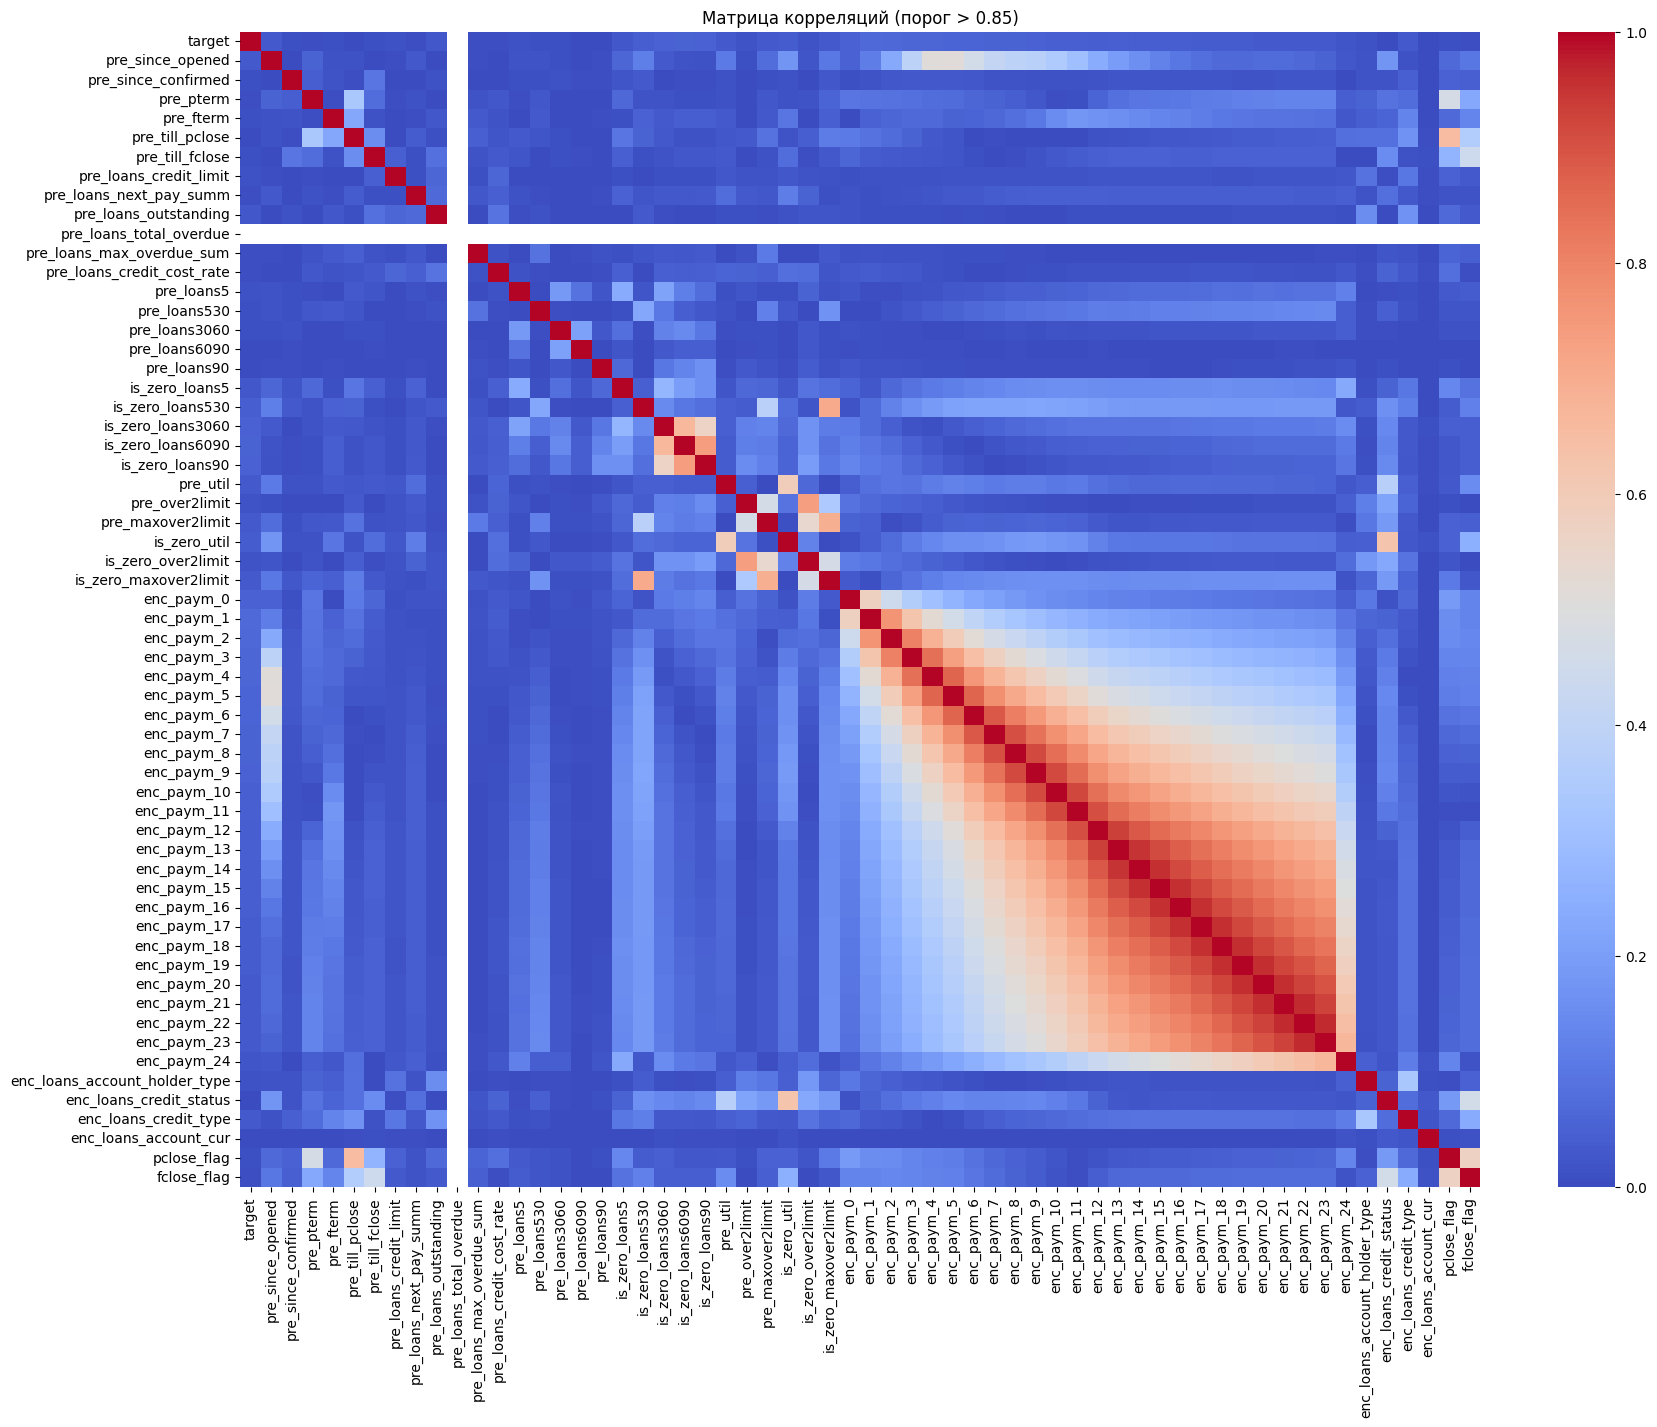

Всего колонок для удаления: 19
Список: {'enc_paym_7', 'enc_paym_15', 'enc_paym_4', 'enc_paym_17', 'enc_paym_22', 'enc_paym_10', 'enc_paym_13', 'enc_paym_16', 'enc_paym_5', 'enc_paym_20', 'enc_paym_23', 'enc_paym_6', 'enc_paym_9', 'enc_paym_19', 'enc_paym_12', 'enc_paym_18', 'enc_paym_8', 'enc_paym_21', 'enc_paym_11'}


In [ ]:
# Selecting a data subset for analysis (first 100,000 rows)
sample_df = df_train.iloc[:100_000].copy()

# Calculating correlation matrix
corr_matrix = sample_df.drop(columns=['id']).corr().abs()

plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, cmap='coolwarm', vmin=0, vmax=1)
plt.title("Correlation Matrix (threshold > 0.85)")
plt.show()

# Setting threshold (typically 0.8-0.9)
THRESHOLD = 0.85

# Finding correlated pairs
correlated_pairs = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if corr_matrix.iloc[i, j] > THRESHOLD:
            colname_i = corr_matrix.columns[i]
            colname_j = corr_matrix.columns[j]
            correlated_pairs.add((colname_i, colname_j))

# Identifying columns to drop
cols_to_drop = set()
for pair in correlated_pairs:
    col1, col2 = pair

    # Remove the one that has higher correlation with other features
    if corr_matrix[col1].mean() > corr_matrix[col2].mean():
        cols_to_drop.add(col2)
    else:
        cols_to_drop.add(col1)

print(f"Total columns to drop: {len(cols_to_drop)}")
print("List:", cols_to_drop)

# Dropping columns
# df_train.drop(columns=cols_to_drop, inplace=True)
# df_test.drop(columns=cols_to_drop, inplace=True)

# Unique values

In [7]:
df_train.nunique().rename('number of unique values').sort_values(ascending=False)

id                         175000
pre_since_opened               20
pre_loans_credit_limit         20
pre_util                       20
pre_maxover2limit              20
                            ...  
is_zero_util                    2
pclose_flag                     2
is_zero_maxover2limit           2
fclose_flag                     2
pre_loans_total_overdue         1
Name: number of unique values, Length: 61, dtype: int64

In [8]:
df_test.nunique().rename('number of unique values').sort_values(ascending=False)

id                               75000
pre_since_opened                    20
pre_loans_credit_limit              20
pre_maxover2limit                   20
pre_util                            20
pre_since_confirmed                 18
pre_pterm                           18
pre_till_pclose                     17
pre_over2limit                      17
pre_fterm                           16
pre_till_fclose                     16
pre_loans_credit_cost_rate          13
pre_loans530                        10
pre_loans_next_pay_summ              7
enc_loans_credit_status              7
enc_loans_credit_type                6
pre_loans_outstanding                5
enc_loans_account_holder_type        5
pre_loans5                           5
pre_loans90                          4
enc_paym_3                           4
enc_paym_2                           4
enc_paym_1                           4
enc_paym_5                           4
enc_paym_0                           4
pre_loans3060            

In [9]:
df_train.drop(columns=['pre_loans_total_overdue'], inplace=True)
df_test.drop(columns=['pre_loans_total_overdue'], inplace=True)

# columns that have no informativity

In [10]:
columns_to_drop = [
    'is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060', 'is_zero_loans6090', 'is_zero_loans90',
    'is_zero_util', 'is_zero_over2limit', 'is_zero_maxover2limit', #informations have in other columns
    'enc_loans_account_cur' #99 percent use the same currency
]

# Drop the columns from the DataFrame (make sure to assign the result to a new DataFrame or use inplace)
# df_train.drop(columns=columns_to_drop, inplace=True)
# df_test.drop(columns=columns_to_drop, inplace=True)

In [11]:
# Identify columns with nunique < 7
categorical_cols = df_test.nunique()[df_test.nunique() < 3].index.tolist()

# Convert these columns to categorical
df_train[categorical_cols] = df_train[categorical_cols].astype("category")
df_test[categorical_cols] = df_test[categorical_cols].astype("category")

# Print converted columns
print("Converted columns to categorical:", categorical_cols)


Converted columns to categorical: ['pre_loans6090', 'is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060', 'is_zero_loans6090', 'is_zero_loans90', 'is_zero_util', 'is_zero_over2limit', 'is_zero_maxover2limit', 'pclose_flag', 'fclose_flag']


In [12]:
df_train.sample(10)

,id,target,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
61344,6697,0,2,9,0,1,10,4,2,0,...,3,3,3,4,1,2,0,1,0,0
40586,74316,0,4,9,14,7,8,8,0,0,...,0,0,0,4,1,2,4,1,0,0
24331,26951,0,14,4,6,1,0,4,8,2,...,3,3,3,4,1,3,3,1,0,0
147074,140426,0,7,0,12,8,12,11,1,1,...,3,3,3,4,1,2,1,1,0,1
114491,141143,0,12,9,4,8,1,11,10,1,...,3,3,3,4,1,2,3,1,1,1
156084,54752,0,12,9,1,16,14,8,2,5,...,3,3,3,4,1,2,4,1,0,0
30220,249148,0,9,9,4,8,1,11,16,3,...,3,3,3,4,1,2,3,1,1,1
162292,237363,0,19,6,2,14,8,8,16,4,...,3,3,3,4,1,2,4,1,0,0
142601,36704,0,7,10,4,8,1,11,17,2,...,3,3,3,4,1,5,3,1,1,1
87526,39766,0,19,9,2,10,8,8,17,1,...,3,3,3,4,1,2,4,1,0,0


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175000 entries, 0 to 174999
Data columns (total 60 columns):
 #   Column                         Non-Null Count   Dtype   
---  ------                         --------------   -----   
 0   id                             175000 non-null  int64   
 1   target                         175000 non-null  int64   
 2   pre_since_opened               175000 non-null  int64   
 3   pre_since_confirmed            175000 non-null  int64   
 4   pre_pterm                      175000 non-null  int64   
 5   pre_fterm                      175000 non-null  int64   
 6   pre_till_pclose                175000 non-null  int64   
 7   pre_till_fclose                175000 non-null  int64   
 8   pre_loans_credit_limit         175000 non-null  int64   
 9   pre_loans_next_pay_summ        175000 non-null  int64   
 10  pre_loans_outstanding          175000 non-null  int64   
 11  pre_loans_max_overdue_sum      175000 non-null  int64   
 12  pre_loans_credit

In [13]:
df_train.describe().T.sort_values(by='std').T

,enc_loans_account_cur,pre_loans3060,pre_loans90,target,pre_loans5,enc_loans_account_holder_type,pre_loans_max_overdue_sum,enc_loans_credit_status,enc_paym_24,pre_over2limit,...,pre_till_fclose,pre_fterm,pre_loans_credit_cost_rate,pre_since_confirmed,pre_till_pclose,pre_pterm,pre_loans_credit_limit,pre_since_opened,pre_util,id
count,175000.000000,175000.000000,175000.000000,175000.000000,175000.000000,175000.000000,175000.000000,175000.000000,175000.000000,175000.000000,...,175000.000000,175000.000000,175000.000000,175000.000000,175000.000000,175000.000000,175000.000000,175000.000000,175000.000000,175000.000000
mean,1.000206,5.000749,8.001034,0.031006,5.988080,1.032274,2.002251,2.218137,3.877903,2.095051,...,9.372623,8.480663,5.400834,7.928571,6.470000,7.960674,9.631691,10.594600,10.921280,124988.536383
std,0.028081,0.052422,0.080029,0.173334,0.261022,0.285895,0.298446,0.450885,0.587919,0.780064,...,3.270286,3.594472,3.747995,4.216644,5.205496,5.444405,5.754680,5.875207,5.908406,72212.682773
min,0.000000,2.000000,8.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,5.000000,8.000000,0.000000,6.000000,1.000000,2.000000,2.000000,4.000000,2.000000,...,8.000000,8.000000,2.000000,6.000000,1.000000,4.000000,5.000000,7.000000,6.000000,62467.500000
50%,1.000000,5.000000,8.000000,0.000000,6.000000,1.000000,2.000000,2.000000,4.000000,2.000000,...,11.000000,8.000000,5.000000,9.000000,8.000000,6.000000,10.000000,11.000000,12.000000,125015.500000
75%,1.000000,5.000000,8.000000,0.000000,6.000000,1.000000,2.000000,2.000000,4.000000,2.000000,...,11.000000,9.000000,8.000000,9.000000,11.000000,14.000000,15.000000,17.000000,16.000000,187562.250000
max,2.000000,8.000000,19.000000,1.000000,16.000000,6.000000,3.000000,6.000000,4.000000,19.000000,...,15.000000,16.000000,13.000000,17.000000,16.000000,17.000000,19.000000,19.000000,19.000000,249999.000000


In [ ]:
# from sklearn.ensemble import IsolationForest

# def detect_outliers_isolation_forest(df, contamination=0.01):
#     """Detects outliers using Isolation Forest."""
#     df_outliers = df_train.copy()
#     iso_forest = IsolationForest(contamination=contamination, random_state=42)
#     df_outliers["outlier"] = iso_forest.fit_predict(df_outliers)
#     df_outliers = df_outliers[df_outliers["outlier"] == 1].drop(columns=["outlier"])
#     return df_outliers

# df_train = detect_outliers_isolation_forest(df_train)

# print("After Isolation Forest:", df_train.shape)

# Train_test split

In [16]:
train_set, test_set = train_test_split(df_train.drop(columns=['id']), test_size=0.30, random_state=1437, stratify=df_train['target'])

X_train, y_train = train_set.drop(columns=['target']), train_set.target
X_test, y_test = test_set.drop(columns=['target']), test_set.target

# Hyperparameter Tuning

In [ ]:
def objective(trial, X, y):
    # Compute class imbalance ratio
    scale_pos_weight = np.sum(y == 0) / np.sum(y == 1)

    # Define hyperparameter search space
    params = {
        'n_jobs' : 5,
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 31, 512, step=16),
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100, step=10),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 0.9),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.7, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 1, 10),
        'lambda_l2': trial.suggest_float('lambda_l2', 1, 10),
        'scale_pos_weight': scale_pos_weight,
        'verbosity': -1,
        'n_estimators': 1000
    }
    
    # Identify categorical columns
    categorical_cols = X.select_dtypes(include=['category']).columns.tolist()

    # Stratified K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []

    for train_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]  
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Convert data to LightGBM Dataset format (for faster training)
        train_data = lgb.Dataset(X_tr, label=y_tr)
        val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

        # Train the model
        model = lgb.train(
            params, train_data,
            valid_sets=[val_data],
            callbacks=[lgb.early_stopping(50, verbose=False)  # Stop if no improvement for 50 rounds
            ]
        )

        # Predict using best iteration
        preds = model.predict(X_val, num_iteration=model.best_iteration)
        auc_scores.append(roc_auc_score(y_val, preds))

    final_auc = np.mean(auc_scores)  # Compute final AUC for this trial

    return final_auc


In [ ]:

# Running Optuna Hyperparameter Tuning
study = optuna.create_study(direction="maximize", study_name="LGBM Classifier")
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=50)

gc.collect()
# Output Best Parameters
best_params = study.best_params
print("\nBest Parameters:", best_params)

[I 2025-03-06 16:39:31,360] A new study created in memory with name: LGBM Classifier
[I 2025-03-06 16:39:37,620] Trial 0 finished with value: 0.7008246507162704 and parameters: {'learning_rate': 0.03346213130635728, 'num_leaves': 159, 'max_depth': 7, 'min_child_samples': 100, 'feature_fraction': 0.6994665596579188, 'bagging_fraction': 0.7867517441209106, 'lambda_l1': 2.0209397626456456, 'lambda_l2': 6.419712874162221}. Best is trial 0 with value: 0.7008246507162704.
[I 2025-03-06 16:39:42,856] Trial 1 finished with value: 0.6891371615570272 and parameters: {'learning_rate': 0.07837971424357178, 'num_leaves': 255, 'max_depth': 11, 'min_child_samples': 100, 'feature_fraction': 0.7725979721351763, 'bagging_fraction': 0.7138316303700152, 'lambda_l1': 2.2949378843928456, 'lambda_l2': 1.8196221185805856}. Best is trial 0 with value: 0.7008246507162704.
[I 2025-03-06 16:39:49,444] Trial 2 finished with value: 0.6998899954394074 and parameters: {'learning_rate': 0.06016748438154733, 'num_leave


Best Parameters: {'learning_rate': 0.03804641919191686, 'num_leaves': 255, 'max_depth': 7, 'min_child_samples': 90, 'feature_fraction': 0.6238652292453049, 'bagging_fraction': 0.7169773915157591, 'lambda_l1': 7.45896500062555, 'lambda_l2': 7.42393637919477}


In [24]:
# Train final model with best parameters
best_params = study.best_params
best_model = lgb.LGBMClassifier(**best_params, n_estimators=1000)
best_model.fit(X_train, y_train)

# Evaluate on test set
test_preds = best_model.predict_proba(X_test, num_iteration=best_model.best_iteration_)[:, 1]
print("Final Test AUC:", roc_auc_score(y_test, test_preds))

Final Test AUC: 0.7131470097615521


In [25]:
df = df_train.drop(columns=['id']).copy()

df['predicted'] = best_model.predict_proba(df[X_train.columns], num_iteration=best_model.best_iteration_)[:,1]
roc_auc_score(df['target'], df['predicted'])

np.float64(0.7751334135015577)

In [26]:
distribution = df[[
            'target',
            'predicted'
            ]]

In [27]:
distribution['proba_rank'] = np.ceil(distribution.predicted / 0.1) * 0.1

In [28]:
to_exc = distribution[['proba_rank', 'target']].groupby(by = ['proba_rank']).sum()

to_exc['cases_cnt'] = distribution[['proba_rank', 'target']].groupby(by = ['proba_rank']).count()

In [29]:
to_exc

,target,cases_cnt
proba_rank,,
0.1,4291,168608
0.2,909,5698
0.3,198,653
0.4,21,34
0.5,7,7


In [30]:
threshold = df.target.value_counts(normalize=True)[1]
print(threshold)
# df['predicted'] = best_model.predict_proba(df.drop(columns=['predicted', 'target']), num_iteration=best_model.best_iteration_)[:,1]
pred_labels = (df['predicted'] >= threshold).astype(int)
roc_auc_score(df['target'], pred_labels)

0.031005714285714286


np.float64(0.7017080704710437)

In [ ]:
def plot_feature_importance(feature_names, feature_scores, top_feats=20, title='Importance', x_label='Importance',
                        y_label='Features'):
    tuples = [(name, round(score, 3)) for name, score in zip(feature_names, feature_scores)]
    tuples = sorted(tuples, key=lambda x: x[1])[-top_feats:]
    labels, values = zip(*tuples)
    _, ax = plt.subplots(1, 1)
    ylocs = np.arange(len(values))
    ax.barh(ylocs, values, align='center', height=0.4)
    for x, y in zip(values, ylocs):
        ax.text(x + 1, y, x, va='center')
    ax.set_yticks(ylocs)
    ax.set_yticklabels(labels)
    xlim = (0, max(values) * 1.1)
    ax.set_xlim(xlim)
    ylim = (-1, len(values))
    ax.set_ylim(ylim)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.grid(True)
    return tuples

[('enc_paym_21', np.int32(10)),
 ('pclose_flag', np.int32(11)),
 ('enc_paym_23', np.int32(14)),
 ('is_zero_over2limit', np.int32(15)),
 ('enc_paym_12', np.int32(21)),
 ('enc_loans_account_holder_type', np.int32(23)),
 ('enc_paym_13', np.int32(24)),
 ('enc_paym_11', np.int32(30)),
 ('enc_paym_7', np.int32(32)),
 ('enc_paym_22', np.int32(32)),
 ('enc_paym_14', np.int32(35)),
 ('pre_loans530', np.int32(43)),
 ('enc_paym_16', np.int32(48)),
 ('enc_paym_19', np.int32(51)),
 ('enc_paym_24', np.int32(57)),
 ('is_zero_maxover2limit', np.int32(83)),
 ('is_zero_loans3060', np.int32(85)),
 ('enc_paym_9', np.int32(85)),
 ('enc_paym_15', np.int32(85)),
 ('fclose_flag', np.int32(85)),
 ('is_zero_loans90', np.int32(86)),
 ('is_zero_loans6090', np.int32(101)),
 ('enc_paym_20', np.int32(111)),
 ('enc_paym_6', np.int32(125)),
 ('is_zero_util', np.int32(134)),
 ('enc_paym_3', np.int32(134)),
 ('enc_paym_10', np.int32(139)),
 ('is_zero_loans5', np.int32(142)),
 ('is_zero_loans530', np.int32(157)),
 ('enc_

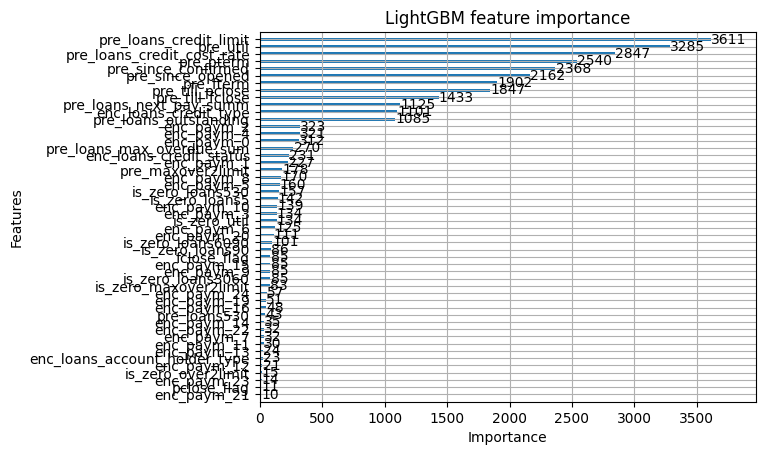

In [32]:
plot_feature_importance(best_model.feature_name_, best_model.feature_importances_, top_feats=50, title='LightGBM feature importance',
                        x_label='Importance')

In [33]:
tuples = [(name, round(score, 3)) for name, score in zip(best_model.feature_name_, best_model.feature_importances_)]
tuples = sorted(tuples, key=lambda x: x[1])
top_selected_feats = [x[0] for x in tuples if x[1] >= 1]

In [34]:
len(top_selected_feats)

53

In [36]:
best_model.fit(X_train[top_selected_feats], y_train)

# Evaluate on test set
test_preds = best_model.predict_proba(X_test[top_selected_feats], num_iteration=best_model.best_iteration_)[:, 1]
print("Final Test AUC:", roc_auc_score(y_test, test_preds))

Final Test AUC: 0.7131557637263134


# No progress

In [ ]:
def objectivex(trial, X, y):
    # Compute class imbalance ratio
    scale_pos_weight = y.value_counts()[0] / y.value_counts()[1]

    # Define hyperparameter search space
    params = {
        'n_jobs' :5,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "booster": "gbtree",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "lambda": trial.suggest_float("lambda", 0, 10),
        "alpha": trial.suggest_float("alpha", 0, 10),
        "scale_pos_weight": scale_pos_weight,
        "verbosity": 0
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []

    for train_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Convert to DMatrix
        dtrain = xgb.DMatrix(X_tr, label=y_tr, enable_categorical=True)
        dval = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)

        # Train the model
        model = xgb.train(
            params,
            dtrain,
            num_boost_round=500,
            evals=[(dval, "validation")],
            early_stopping_rounds=50,
            verbose_eval=False
        )

        # Use iteration_range instead of ntree_limit
        preds = model.predict(dval, iteration_range=(0, model.best_iteration + 1))
        auc_scores.append(roc_auc_score(y_val, preds))

    final_auc = np.mean(auc_scores)  # Compute final AUC for this trial

    return final_auc

In [ ]:
# Run Optuna
studyx = optuna.create_study(direction="maximize", study_name="XGBOOST Classifier")
studyx.optimize(lambda trial: objectivex(trial, X_train, y_train), n_trials=50)

gc.collect()
# Print best parameters
print("Best Hyperparameters:", studyx.best_params)

[I 2025-03-06 16:47:40,025] A new study created in memory with name: XGBOOST Classifier
[I 2025-03-06 16:47:48,334] Trial 0 finished with value: 0.6834448776544644 and parameters: {'learning_rate': 0.022746112159111563, 'max_depth': 9, 'min_child_weight': 8, 'gamma': 2.6052838732723242, 'subsample': 0.5638702915946103, 'colsample_bytree': 0.9622314853017853, 'lambda': 0.5137628491353241, 'alpha': 4.7117276066982585}. Best is trial 0 with value: 0.6834448776544644.


Trial 0 - AUC: 0.68344


[I 2025-03-06 16:48:06,182] Trial 1 finished with value: 0.7006616934712084 and parameters: {'learning_rate': 0.01527250333515969, 'max_depth': 6, 'min_child_weight': 9, 'gamma': 1.6173252004042227, 'subsample': 0.6437808883847005, 'colsample_bytree': 0.7503404141359377, 'lambda': 3.0965487483293797, 'alpha': 8.217471760448001}. Best is trial 1 with value: 0.7006616934712084.


Trial 1 - AUC: 0.70066


[I 2025-03-06 16:48:18,185] Trial 2 finished with value: 0.7008554417497969 and parameters: {'learning_rate': 0.0370702330171166, 'max_depth': 5, 'min_child_weight': 4, 'gamma': 2.6134727174702217, 'subsample': 0.5922311732460577, 'colsample_bytree': 0.8956378775017775, 'lambda': 6.931163005194037, 'alpha': 0.4301787710458327}. Best is trial 2 with value: 0.7008554417497969.


Trial 2 - AUC: 0.70086


[I 2025-03-06 16:48:26,244] Trial 3 finished with value: 0.6918414746684968 and parameters: {'learning_rate': 0.0522430062168962, 'max_depth': 7, 'min_child_weight': 6, 'gamma': 3.843182007048398, 'subsample': 0.5635302317244604, 'colsample_bytree': 0.9119657582656778, 'lambda': 3.0433646124035088, 'alpha': 4.585779203039074}. Best is trial 2 with value: 0.7008554417497969.


Trial 3 - AUC: 0.69184


[I 2025-03-06 16:48:32,159] Trial 4 finished with value: 0.6819694982220905 and parameters: {'learning_rate': 0.10978446533322071, 'max_depth': 9, 'min_child_weight': 8, 'gamma': 1.389560747063373, 'subsample': 0.8854014127064869, 'colsample_bytree': 0.9117771223056197, 'lambda': 7.298584132248037, 'alpha': 4.596313241392752}. Best is trial 2 with value: 0.7008554417497969.


Trial 4 - AUC: 0.68197


[I 2025-03-06 16:48:39,907] Trial 5 finished with value: 0.6779946209338646 and parameters: {'learning_rate': 0.03436066231770313, 'max_depth': 11, 'min_child_weight': 8, 'gamma': 2.758314644309449, 'subsample': 0.5421609870821835, 'colsample_bytree': 0.532161015294035, 'lambda': 1.9944007485467208, 'alpha': 0.4821385072116624}. Best is trial 2 with value: 0.7008554417497969.


Trial 5 - AUC: 0.67799


[I 2025-03-06 16:48:47,902] Trial 6 finished with value: 0.6818017220988506 and parameters: {'learning_rate': 0.034063589270723664, 'max_depth': 9, 'min_child_weight': 10, 'gamma': 4.321641442132444, 'subsample': 0.5761306642265354, 'colsample_bytree': 0.9600544115907336, 'lambda': 2.1306315683238997, 'alpha': 0.03754422888824882}. Best is trial 2 with value: 0.7008554417497969.


Trial 6 - AUC: 0.68180


[I 2025-03-06 16:48:52,552] Trial 7 finished with value: 0.6917638487592335 and parameters: {'learning_rate': 0.2411325793763678, 'max_depth': 6, 'min_child_weight': 1, 'gamma': 1.5686680085623028, 'subsample': 0.7210092329851674, 'colsample_bytree': 0.9420591212085464, 'lambda': 8.738215860754991, 'alpha': 2.5737515692357347}. Best is trial 2 with value: 0.7008554417497969.


Trial 7 - AUC: 0.69176


[I 2025-03-06 16:49:14,702] Trial 8 finished with value: 0.6988163503466966 and parameters: {'learning_rate': 0.012891904432351413, 'max_depth': 3, 'min_child_weight': 9, 'gamma': 1.623688110697152, 'subsample': 0.662451800397367, 'colsample_bytree': 0.9020706154902571, 'lambda': 4.457431268153486, 'alpha': 2.05445671829834}. Best is trial 2 with value: 0.7008554417497969.


Trial 8 - AUC: 0.69882


[I 2025-03-06 16:49:37,311] Trial 9 finished with value: 0.7044123711290378 and parameters: {'learning_rate': 0.020998249131215688, 'max_depth': 4, 'min_child_weight': 10, 'gamma': 2.9056289511988505, 'subsample': 0.7258922676269342, 'colsample_bytree': 0.6416195687275139, 'lambda': 9.468527050006013, 'alpha': 7.782314106070723}. Best is trial 9 with value: 0.7044123711290378.


Trial 9 - AUC: 0.70441


[I 2025-03-06 16:49:48,462] Trial 10 finished with value: 0.7043412375824458 and parameters: {'learning_rate': 0.09905082932339389, 'max_depth': 3, 'min_child_weight': 5, 'gamma': 0.28747187552216724, 'subsample': 0.9905200848392526, 'colsample_bytree': 0.5434457547667133, 'lambda': 9.697585155074707, 'alpha': 9.94762040696082}. Best is trial 9 with value: 0.7044123711290378.


Trial 10 - AUC: 0.70434


[I 2025-03-06 16:49:58,141] Trial 11 finished with value: 0.7032238333919717 and parameters: {'learning_rate': 0.10550289874495739, 'max_depth': 3, 'min_child_weight': 5, 'gamma': 0.18353775095527336, 'subsample': 0.9800004045369131, 'colsample_bytree': 0.5385896077398751, 'lambda': 9.881379872143388, 'alpha': 9.871919561923178}. Best is trial 9 with value: 0.7044123711290378.


Trial 11 - AUC: 0.70322


[I 2025-03-06 16:50:05,489] Trial 12 finished with value: 0.7031913334570239 and parameters: {'learning_rate': 0.10252822159406133, 'max_depth': 4, 'min_child_weight': 3, 'gamma': 0.1822940608508165, 'subsample': 0.8122105226569865, 'colsample_bytree': 0.6438347702709847, 'lambda': 9.873754417412982, 'alpha': 7.625987344570262}. Best is trial 9 with value: 0.7044123711290378.


Trial 12 - AUC: 0.70319


[I 2025-03-06 16:50:11,713] Trial 13 finished with value: 0.7005425982614282 and parameters: {'learning_rate': 0.2025659537033332, 'max_depth': 4, 'min_child_weight': 6, 'gamma': 3.5667427181398526, 'subsample': 0.8077893029389771, 'colsample_bytree': 0.6393334472476612, 'lambda': 7.494845011668886, 'alpha': 9.92190019498716}. Best is trial 9 with value: 0.7044123711290378.


Trial 13 - AUC: 0.70054


[I 2025-03-06 16:50:24,036] Trial 14 finished with value: 0.7037463519623893 and parameters: {'learning_rate': 0.07343648833837274, 'max_depth': 3, 'min_child_weight': 3, 'gamma': 0.8403697230240388, 'subsample': 0.9591718178582908, 'colsample_bytree': 0.6320382028477962, 'lambda': 5.8063366862338075, 'alpha': 7.279325567580274}. Best is trial 9 with value: 0.7044123711290378.


Trial 14 - AUC: 0.70375


[I 2025-03-06 16:50:42,162] Trial 15 finished with value: 0.7036663477441454 and parameters: {'learning_rate': 0.022672477529473236, 'max_depth': 5, 'min_child_weight': 7, 'gamma': 3.2670882325032506, 'subsample': 0.7534628658900357, 'colsample_bytree': 0.7485974534528181, 'lambda': 8.593224734333461, 'alpha': 8.548228307173389}. Best is trial 9 with value: 0.7044123711290378.


Trial 15 - AUC: 0.70367


[I 2025-03-06 16:50:53,405] Trial 16 finished with value: 0.6911301564381441 and parameters: {'learning_rate': 0.010172137555738803, 'max_depth': 12, 'min_child_weight': 5, 'gamma': 4.586033034527794, 'subsample': 0.8894660535941277, 'colsample_bytree': 0.5803620094672185, 'lambda': 5.6356921891003555, 'alpha': 6.122367888667196}. Best is trial 9 with value: 0.7044123711290378.


Trial 16 - AUC: 0.69113


[I 2025-03-06 16:51:02,840] Trial 17 finished with value: 0.7034372741413879 and parameters: {'learning_rate': 0.0619077584521027, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 2.1838977031046602, 'subsample': 0.8989878669915945, 'colsample_bytree': 0.7101650888134068, 'lambda': 8.591386542193035, 'alpha': 6.479220984367426}. Best is trial 9 with value: 0.7044123711290378.


Trial 17 - AUC: 0.70344


[I 2025-03-06 16:51:08,446] Trial 18 finished with value: 0.6952680692803442 and parameters: {'learning_rate': 0.13858441717899386, 'max_depth': 7, 'min_child_weight': 3, 'gamma': 0.8325276601077958, 'subsample': 0.7467344584118495, 'colsample_bytree': 0.502872253953152, 'lambda': 8.918390454357436, 'alpha': 9.075101604578657}. Best is trial 9 with value: 0.7044123711290378.


Trial 18 - AUC: 0.69527


[I 2025-03-06 16:51:31,149] Trial 19 finished with value: 0.703425124263445 and parameters: {'learning_rate': 0.019958960905446563, 'max_depth': 4, 'min_child_weight': 10, 'gamma': 2.119150250349296, 'subsample': 0.8381727676574933, 'colsample_bytree': 0.8223490914123506, 'lambda': 6.5905515356535584, 'alpha': 5.975696979687055}. Best is trial 9 with value: 0.7044123711290378.


Trial 19 - AUC: 0.70343


[I 2025-03-06 16:51:39,790] Trial 20 finished with value: 0.6957505293343331 and parameters: {'learning_rate': 0.04605693794660477, 'max_depth': 8, 'min_child_weight': 7, 'gamma': 3.050900611179276, 'subsample': 0.7094539467952672, 'colsample_bytree': 0.59176293326004, 'lambda': 7.9652351906892385, 'alpha': 9.053975733504055}. Best is trial 9 with value: 0.7044123711290378.


Trial 20 - AUC: 0.69575


[I 2025-03-06 16:51:52,603] Trial 21 finished with value: 0.7030162889539396 and parameters: {'learning_rate': 0.08495913562828354, 'max_depth': 3, 'min_child_weight': 3, 'gamma': 0.6631123491972835, 'subsample': 0.9984135304694063, 'colsample_bytree': 0.6600668962790486, 'lambda': 5.591720356962968, 'alpha': 7.208730747825513}. Best is trial 9 with value: 0.7044123711290378.


Trial 21 - AUC: 0.70302


[I 2025-03-06 16:52:05,057] Trial 22 finished with value: 0.7040439827938795 and parameters: {'learning_rate': 0.07380929059710883, 'max_depth': 3, 'min_child_weight': 4, 'gamma': 0.8694364371340263, 'subsample': 0.9438251390558796, 'colsample_bytree': 0.6057235583102163, 'lambda': 9.916418775014384, 'alpha': 7.14257745782577}. Best is trial 9 with value: 0.7044123711290378.


Trial 22 - AUC: 0.70404


[I 2025-03-06 16:52:11,861] Trial 23 finished with value: 0.7041229897397476 and parameters: {'learning_rate': 0.16430424154686782, 'max_depth': 4, 'min_child_weight': 4, 'gamma': 0.5132035081406032, 'subsample': 0.9391029590768611, 'colsample_bytree': 0.5846219314653872, 'lambda': 9.996171701712896, 'alpha': 8.187720315066327}. Best is trial 9 with value: 0.7044123711290378.


Trial 23 - AUC: 0.70412


[I 2025-03-06 16:52:17,839] Trial 24 finished with value: 0.7013358248104027 and parameters: {'learning_rate': 0.1902550244630466, 'max_depth': 4, 'min_child_weight': 4, 'gamma': 0.3228168108682017, 'subsample': 0.8509159189045463, 'colsample_bytree': 0.682538537126521, 'lambda': 9.413526112126258, 'alpha': 8.31855891937082}. Best is trial 9 with value: 0.7044123711290378.


Trial 24 - AUC: 0.70134


[I 2025-03-06 16:52:22,883] Trial 25 finished with value: 0.6951251603486703 and parameters: {'learning_rate': 0.29916201534821035, 'max_depth': 6, 'min_child_weight': 2, 'gamma': 2.141874155155304, 'subsample': 0.929523059029591, 'colsample_bytree': 0.5663507319131516, 'lambda': 7.931707664170676, 'alpha': 9.266690346238605}. Best is trial 9 with value: 0.7044123711290378.


Trial 25 - AUC: 0.69513


[I 2025-03-06 16:52:29,422] Trial 26 finished with value: 0.7007225594469402 and parameters: {'learning_rate': 0.1650970383214526, 'max_depth': 5, 'min_child_weight': 5, 'gamma': 1.2744973063404363, 'subsample': 0.6538463692572607, 'colsample_bytree': 0.5483567211024439, 'lambda': 9.148236698626317, 'alpha': 5.527570821659429}. Best is trial 9 with value: 0.7044123711290378.


Trial 26 - AUC: 0.70072


[I 2025-03-06 16:52:36,878] Trial 27 finished with value: 0.7011639704326286 and parameters: {'learning_rate': 0.14264822963219856, 'max_depth': 4, 'min_child_weight': 6, 'gamma': 0.03430705775046994, 'subsample': 0.5086876026902336, 'colsample_bytree': 0.5063352318685356, 'lambda': 8.15574640217202, 'alpha': 3.4742180101622653}. Best is trial 9 with value: 0.7044123711290378.


Trial 27 - AUC: 0.70116


[I 2025-03-06 16:52:43,680] Trial 28 finished with value: 0.701070920970108 and parameters: {'learning_rate': 0.12646985515605452, 'max_depth': 5, 'min_child_weight': 7, 'gamma': 3.8800308028553276, 'subsample': 0.789436725460096, 'colsample_bytree': 0.7054689228990392, 'lambda': 9.37558092008367, 'alpha': 7.943443932066996}. Best is trial 9 with value: 0.7044123711290378.


Trial 28 - AUC: 0.70107


[I 2025-03-06 16:52:50,886] Trial 29 finished with value: 0.6828738549491333 and parameters: {'learning_rate': 0.08596842479307744, 'max_depth': 10, 'min_child_weight': 2, 'gamma': 1.228761728452115, 'subsample': 0.9233269525155482, 'colsample_bytree': 0.6067139460738614, 'lambda': 0.4472388215945262, 'alpha': 9.34836324106934}. Best is trial 9 with value: 0.7044123711290378.


Trial 29 - AUC: 0.68287


[I 2025-03-06 16:53:05,141] Trial 30 finished with value: 0.6930733083622125 and parameters: {'learning_rate': 0.016890515164045317, 'max_depth': 8, 'min_child_weight': 4, 'gamma': 0.559595761612913, 'subsample': 0.8614981418864418, 'colsample_bytree': 0.8154001135158182, 'lambda': 6.358148187422486, 'alpha': 6.670874832623247}. Best is trial 9 with value: 0.7044123711290378.


Trial 30 - AUC: 0.69307


[I 2025-03-06 16:53:19,663] Trial 31 finished with value: 0.703473253613683 and parameters: {'learning_rate': 0.06621650265039278, 'max_depth': 3, 'min_child_weight': 4, 'gamma': 0.9361575641927268, 'subsample': 0.9614102598210235, 'colsample_bytree': 0.6046338574387145, 'lambda': 9.95697702633055, 'alpha': 7.160762867565104}. Best is trial 9 with value: 0.7044123711290378.


Trial 31 - AUC: 0.70347


[I 2025-03-06 16:53:32,612] Trial 32 finished with value: 0.7044778305651765 and parameters: {'learning_rate': 0.048643814044931004, 'max_depth': 4, 'min_child_weight': 5, 'gamma': 0.455653819750486, 'subsample': 0.9319580849440782, 'colsample_bytree': 0.6080279172367757, 'lambda': 9.99055133919173, 'alpha': 8.52061857915285}. Best is trial 32 with value: 0.7044778305651765.


Trial 32 - AUC: 0.70448


[I 2025-03-06 16:53:42,391] Trial 33 finished with value: 0.7023009531137714 and parameters: {'learning_rate': 0.044482734801160176, 'max_depth': 6, 'min_child_weight': 5, 'gamma': 0.3865160987201556, 'subsample': 0.9976921813225303, 'colsample_bytree': 0.5658274534458412, 'lambda': 9.244528546187125, 'alpha': 8.66394495802694}. Best is trial 32 with value: 0.7044778305651765.


Trial 33 - AUC: 0.70230


[I 2025-03-06 16:54:00,286] Trial 34 finished with value: 0.7037164461854927 and parameters: {'learning_rate': 0.02578780244213353, 'max_depth': 4, 'min_child_weight': 6, 'gamma': 1.8544302440159135, 'subsample': 0.9008382715566237, 'colsample_bytree': 0.6741709297735259, 'lambda': 4.134076620766881, 'alpha': 7.9280183400083075}. Best is trial 32 with value: 0.7044778305651765.


Trial 34 - AUC: 0.70372


[I 2025-03-06 16:54:17,643] Trial 35 finished with value: 0.7035567484187593 and parameters: {'learning_rate': 0.025026323426990262, 'max_depth': 5, 'min_child_weight': 9, 'gamma': 0.012910486781701536, 'subsample': 0.6236224194803393, 'colsample_bytree': 0.6211387634437667, 'lambda': 8.351677472743628, 'alpha': 9.870865862583598}. Best is trial 32 with value: 0.7044778305651765.


Trial 35 - AUC: 0.70356


[I 2025-03-06 16:54:30,152] Trial 36 finished with value: 0.7002702182331543 and parameters: {'learning_rate': 0.03024353065679771, 'max_depth': 7, 'min_child_weight': 5, 'gamma': 2.381835425461052, 'subsample': 0.6818095968159167, 'colsample_bytree': 0.5371416682817857, 'lambda': 7.327946148609558, 'alpha': 8.74847259199817}. Best is trial 32 with value: 0.7044778305651765.


Trial 36 - AUC: 0.70027


[I 2025-03-06 16:54:44,509] Trial 37 finished with value: 0.703015357486266 and parameters: {'learning_rate': 0.041490823090633566, 'max_depth': 4, 'min_child_weight': 7, 'gamma': 1.1233083463827103, 'subsample': 0.9208877811621731, 'colsample_bytree': 0.9988081190600564, 'lambda': 9.307779159813906, 'alpha': 5.261515072196854}. Best is trial 32 with value: 0.7044778305651765.


Trial 37 - AUC: 0.70302


[I 2025-03-06 16:54:53,557] Trial 38 finished with value: 0.6988197676420127 and parameters: {'learning_rate': 0.05686294358763931, 'max_depth': 6, 'min_child_weight': 6, 'gamma': 2.78713555082083, 'subsample': 0.9699979597809063, 'colsample_bytree': 0.729948669791654, 'lambda': 7.555232960951663, 'alpha': 4.051172724097482}. Best is trial 32 with value: 0.7044778305651765.


Trial 38 - AUC: 0.69882


[I 2025-03-06 16:54:59,593] Trial 39 finished with value: 0.7018604894795922 and parameters: {'learning_rate': 0.2452766218619791, 'max_depth': 3, 'min_child_weight': 8, 'gamma': 1.7675302350143005, 'subsample': 0.7664794593572651, 'colsample_bytree': 0.7958533090644061, 'lambda': 8.85090404714945, 'alpha': 8.068902302579747}. Best is trial 32 with value: 0.7044778305651765.


Trial 39 - AUC: 0.70186


[I 2025-03-06 16:55:07,891] Trial 40 finished with value: 0.7021681631534751 and parameters: {'learning_rate': 0.09483689314666474, 'max_depth': 5, 'min_child_weight': 2, 'gamma': 0.5004685196386238, 'subsample': 0.6210390373400947, 'colsample_bytree': 0.5664880032065408, 'lambda': 3.066117480633438, 'alpha': 9.253830289311075}. Best is trial 32 with value: 0.7044778305651765.


Trial 40 - AUC: 0.70217


[I 2025-03-06 16:55:18,525] Trial 41 finished with value: 0.7041361630061888 and parameters: {'learning_rate': 0.11559488049852165, 'max_depth': 3, 'min_child_weight': 4, 'gamma': 0.9930185287243466, 'subsample': 0.9382264414058699, 'colsample_bytree': 0.6023603317334456, 'lambda': 9.94192737900468, 'alpha': 7.645161758317828}. Best is trial 32 with value: 0.7044778305651765.


Trial 41 - AUC: 0.70414


[I 2025-03-06 16:55:27,938] Trial 42 finished with value: 0.7040591889934715 and parameters: {'learning_rate': 0.11574774088492411, 'max_depth': 3, 'min_child_weight': 4, 'gamma': 0.5068889935544632, 'subsample': 0.8750748656072157, 'colsample_bytree': 0.5238772479710415, 'lambda': 9.569693288670718, 'alpha': 7.639152368508303}. Best is trial 32 with value: 0.7044778305651765.


Trial 42 - AUC: 0.70406


[I 2025-03-06 16:55:34,113] Trial 43 finished with value: 0.7023170436528623 and parameters: {'learning_rate': 0.2038453702145736, 'max_depth': 4, 'min_child_weight': 5, 'gamma': 0.7028744409820586, 'subsample': 0.9469495857857273, 'colsample_bytree': 0.6585319714676706, 'lambda': 9.675374545126413, 'alpha': 9.592135586098367}. Best is trial 32 with value: 0.7044778305651765.


Trial 43 - AUC: 0.70232


[I 2025-03-06 16:55:42,624] Trial 44 finished with value: 0.7033038972414879 and parameters: {'learning_rate': 0.16703302883597748, 'max_depth': 3, 'min_child_weight': 4, 'gamma': 1.006132480042629, 'subsample': 0.9872350994016086, 'colsample_bytree': 0.5800970560107842, 'lambda': 8.910422785533164, 'alpha': 8.450428426405697}. Best is trial 32 with value: 0.7044778305651765.


Trial 44 - AUC: 0.70330


[I 2025-03-06 16:55:56,792] Trial 45 finished with value: 0.7035540739885479 and parameters: {'learning_rate': 0.05209951226672642, 'max_depth': 4, 'min_child_weight': 3, 'gamma': 1.480465497140431, 'subsample': 0.828039971573043, 'colsample_bytree': 0.6210736280178801, 'lambda': 1.1128633220409068, 'alpha': 6.613517636804397}. Best is trial 32 with value: 0.7044778305651765.


Trial 45 - AUC: 0.70355


[I 2025-03-06 16:56:05,094] Trial 46 finished with value: 0.7026329086763057 and parameters: {'learning_rate': 0.15400846820620245, 'max_depth': 3, 'min_child_weight': 6, 'gamma': 0.24958922996626087, 'subsample': 0.9106427194415513, 'colsample_bytree': 0.5536197332341135, 'lambda': 8.411408639556832, 'alpha': 1.4217716790826507}. Best is trial 32 with value: 0.7044778305651765.


Trial 46 - AUC: 0.70263


[I 2025-03-06 16:56:32,925] Trial 47 finished with value: 0.703351970172117 and parameters: {'learning_rate': 0.013889976366994555, 'max_depth': 4, 'min_child_weight': 8, 'gamma': 4.967107136983933, 'subsample': 0.7068813667512984, 'colsample_bytree': 0.526699820931439, 'lambda': 9.98098109559536, 'alpha': 8.94524377621437}. Best is trial 32 with value: 0.7044778305651765.


Trial 47 - AUC: 0.70335


[I 2025-03-06 16:56:39,410] Trial 48 finished with value: 0.6994252187809433 and parameters: {'learning_rate': 0.11998331390912344, 'max_depth': 5, 'min_child_weight': 4, 'gamma': 3.1663949930009454, 'subsample': 0.9418345490107858, 'colsample_bytree': 0.6408944319221047, 'lambda': 3.88326235488051, 'alpha': 7.8378939242926045}. Best is trial 32 with value: 0.7044778305651765.


Trial 48 - AUC: 0.69943


[I 2025-03-06 16:56:58,993] Trial 49 finished with value: 0.6878001074534472 and parameters: {'learning_rate': 0.010172494744769748, 'max_depth': 3, 'min_child_weight': 5, 'gamma': 3.5002453288558764, 'subsample': 0.9762454782677484, 'colsample_bytree': 0.5931139096402341, 'lambda': 6.921943119910451, 'alpha': 9.995638653198831}. Best is trial 32 with value: 0.7044778305651765.


Trial 49 - AUC: 0.68780
Best Hyperparameters: {'learning_rate': 0.048643814044931004, 'max_depth': 4, 'min_child_weight': 5, 'gamma': 0.455653819750486, 'subsample': 0.9319580849440782, 'colsample_bytree': 0.6080279172367757, 'lambda': 9.99055133919173, 'alpha': 8.52061857915285}


In [39]:
# Train final model with best parameters
best_paramsx = studyx.best_params
x_model = xgb.XGBClassifier(**best_paramsx, n_estimators=1000,
    early_stopping_rounds=50,
    eval_metric="auc",
    verbose=False,
    enable_categorical=True)
x_model.fit(
    X_train[top_selected_feats], y_train, eval_set=[(X_test[top_selected_feats], y_test)]
)

# Now use the best number of trees for prediction
test_preds = x_model.predict_proba(X_test[top_selected_feats])[:, 1]
print("Final Test AUC:", roc_auc_score(y_test, test_preds))


[0]	validation_0-auc:0.62544
[1]	validation_0-auc:0.64791
[2]	validation_0-auc:0.65140
[3]	validation_0-auc:0.65549
[4]	validation_0-auc:0.65856
[5]	validation_0-auc:0.66230
[6]	validation_0-auc:0.66217
[7]	validation_0-auc:0.66438
[8]	validation_0-auc:0.66490
[9]	validation_0-auc:0.66640
[10]	validation_0-auc:0.66586
[11]	validation_0-auc:0.66627
[12]	validation_0-auc:0.66650
[13]	validation_0-auc:0.66711
[14]	validation_0-auc:0.66813
[15]	validation_0-auc:0.66975
[16]	validation_0-auc:0.67129
[17]	validation_0-auc:0.67187
[18]	validation_0-auc:0.67223
[19]	validation_0-auc:0.67190
[20]	validation_0-auc:0.67242
[21]	validation_0-auc:0.67281
[22]	validation_0-auc:0.67360
[23]	validation_0-auc:0.67427
[24]	validation_0-auc:0.67456
[25]	validation_0-auc:0.67518
[26]	validation_0-auc:0.67731
[27]	validation_0-auc:0.67880
[28]	validation_0-auc:0.67870
[29]	validation_0-auc:0.67945
[30]	validation_0-auc:0.67963
[31]	validation_0-auc:0.68007
[32]	validation_0-auc:0.68117
[33]	validation_0-au

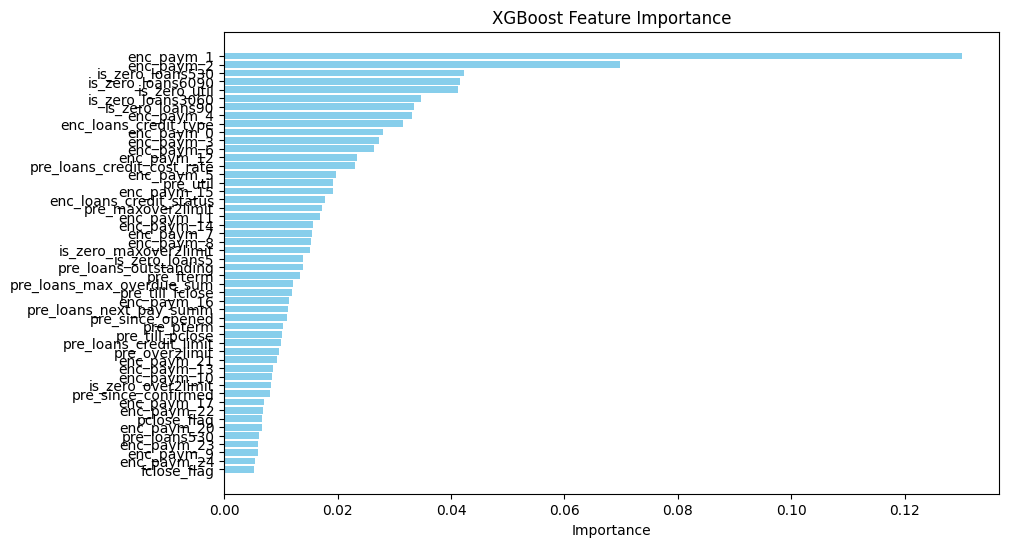

In [40]:
def plot_feature_importance(feature_names, importances, top_feats=50, title="XGBoost Feature Importance", x_label="Importance"):
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False).head(top_feats)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="skyblue")
    plt.gca().invert_yaxis()  # Highest importance on top
    plt.xlabel(x_label)
    plt.title(title)
    plt.show()

# Use `X_train.columns` instead of `x_model.feature_name_`
plot_feature_importance(x_model.feature_names_in_, x_model.feature_importances_, top_feats=50)


In [41]:
tuples = [(name, round(score, 3)) for name, score in zip(x_model.feature_names_in_, x_model.feature_importances_)]
tuples = sorted(tuples, key=lambda x: x[1])
top_selected_feats = [x[0] for x in tuples if x[1] != 0]

In [42]:
len(top_selected_feats)

51

In [44]:
x_model.fit(X_train[top_selected_feats], y_train, eval_set=[(X_test[top_selected_feats], y_test)])

# Evaluate on test set
test_preds = x_model.predict_proba(X_test[top_selected_feats])[:, 1]
print("Final Test AUC:", roc_auc_score(y_test, test_preds))

[0]	validation_0-auc:0.62021
[1]	validation_0-auc:0.63786
[2]	validation_0-auc:0.65566
[3]	validation_0-auc:0.66092
[4]	validation_0-auc:0.66445
[5]	validation_0-auc:0.66656
[6]	validation_0-auc:0.66750
[7]	validation_0-auc:0.66871
[8]	validation_0-auc:0.66802
[9]	validation_0-auc:0.66918
[10]	validation_0-auc:0.67149
[11]	validation_0-auc:0.67057
[12]	validation_0-auc:0.67110
[13]	validation_0-auc:0.67098
[14]	validation_0-auc:0.67128
[15]	validation_0-auc:0.67184
[16]	validation_0-auc:0.67178
[17]	validation_0-auc:0.67247
[18]	validation_0-auc:0.67228
[19]	validation_0-auc:0.67329
[20]	validation_0-auc:0.67323
[21]	validation_0-auc:0.67350
[22]	validation_0-auc:0.67404
[23]	validation_0-auc:0.67463
[24]	validation_0-auc:0.67561
[25]	validation_0-auc:0.67605
[26]	validation_0-auc:0.67616
[27]	validation_0-auc:0.67629
[28]	validation_0-auc:0.67747
[29]	validation_0-auc:0.68019
[30]	validation_0-auc:0.68113
[31]	validation_0-auc:0.68221
[32]	validation_0-auc:0.68269
[33]	validation_0-au

In [45]:
best_model.fit(X_train[top_selected_feats], y_train)

# Evaluate on test set
test_preds = best_model.predict_proba(X_test[top_selected_feats], num_iteration=best_model.best_iteration_)[:, 1]
print("Final Test AUC:", roc_auc_score(y_test, test_preds))

Final Test AUC: 0.7137729001303266


In [ ]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

lgb_preds = np.zeros(len(X_train[top_selected_feats]))
xgb_preds = np.zeros(len(X_train[top_selected_feats]))
stacking_features = np.zeros((len(X_train[top_selected_feats]), 2))
meta_targets = np.zeros(len(X_train[top_selected_feats]))  # Store correct y_train for stacking

for train_idx, val_idx in skf.split(X_train[top_selected_feats], y_train):
    X_tr, X_val = X_train[top_selected_feats].iloc[train_idx], X_train[top_selected_feats].iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Train LightGBM
    best_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)])

    # Train XGBoost
    x_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)])

    # Store stacking features
    stacking_features[val_idx, 0] = best_model.predict_proba(X_val, num_iteration=best_model.best_iteration_)[:, 1]
    stacking_features[val_idx, 1] = x_model.predict_proba(X_val)[:, 1]
    meta_targets[val_idx] = y_val  # Correct target values for stacking

# Train final meta-model
meta_model = LogisticRegression()
meta_model.fit(stacking_features, meta_targets)  # Use meta_targets (corrected y_train)

# Get final predictions
final_preds = meta_model.predict_proba(stacking_features)[:, 1]
gc.collect()
# Evaluate
print("Stacking AUC:", roc_auc_score(meta_targets, final_preds))  # Use correct y_train



[0]	validation_0-auc:0.59579
[1]	validation_0-auc:0.61441
[2]	validation_0-auc:0.63140
[3]	validation_0-auc:0.63803
[4]	validation_0-auc:0.63813
[5]	validation_0-auc:0.63851
[6]	validation_0-auc:0.63710
[7]	validation_0-auc:0.63991
[8]	validation_0-auc:0.63964
[9]	validation_0-auc:0.64029
[10]	validation_0-auc:0.64089
[11]	validation_0-auc:0.64119
[12]	validation_0-auc:0.64039
[13]	validation_0-auc:0.63956
[14]	validation_0-auc:0.64164
[15]	validation_0-auc:0.64248
[16]	validation_0-auc:0.64380
[17]	validation_0-auc:0.64336
[18]	validation_0-auc:0.64269
[19]	validation_0-auc:0.64330
[20]	validation_0-auc:0.64284
[21]	validation_0-auc:0.64312
[22]	validation_0-auc:0.64364
[23]	validation_0-auc:0.64555
[24]	validation_0-auc:0.64477
[25]	validation_0-auc:0.64542
[26]	validation_0-auc:0.64596
[27]	validation_0-auc:0.64741
[28]	validation_0-auc:0.64764
[29]	validation_0-auc:0.64940
[30]	validation_0-auc:0.65020
[31]	validation_0-auc:0.65133
[32]	validation_0-auc:0.65264
[33]	validation_0-au

In [49]:
# Get predictions from base models on X_test
lgb_test_preds = best_model.predict_proba(X_test[top_selected_feats])[:, 1]
xgb_test_preds = x_model.predict_proba(X_test[top_selected_feats])[:, 1]

# Stack test predictions
stacked_test_features = np.column_stack((lgb_test_preds, xgb_test_preds))

# Meta-model predictions
final_test_preds = meta_model.predict_proba(stacked_test_features)[:, 1]

# Evaluate Stacking Model
stacking_auc = roc_auc_score(y_test, final_test_preds)
print(f"Final Stacking Model AUC: {stacking_auc:.4f}")


Final Stacking Model AUC: 0.7130


In [52]:
test_predictions = x_model.predict_proba(df_test[top_selected_feats])[:, 1]

In [ ]:
# Create path to outputs directory (relative to current notebook in notebooks/)
outputs_dir = Path.cwd().parent / 'outputs'
outputs_dir.mkdir(exist_ok=True)  # Create the folder if it doesn't exist

# Create submission DataFrame
submission = pd.DataFrame({'id': df_test['id'], 'prediction': test_predictions})

# Save to outputs folder
submission_path = outputs_dir / 'output_data.csv'
submission.to_csv(submission_path, index=False)

print(f"The file is saved successfully to: {submission_path}")

The file is saved successfully


In [ ]:
filename = 'model_v1.pkl'
pickle.dump(x_model, open(filename, 'wb'))

# Due to low auc score, I decided not to drop correlated columns, but i dropped columns which has no informativity such as 'pre_loans_total_overdue', 'is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060', 'is_zero_loans6090', 'is_zero_loans90', 'is_zero_util', 'is_zero_over2limit', 'is_zero_maxover2limit'. the best model was xgboost model with auc = 0.716, i tried xgboost model which auc 0.710, tried to stack them, due to their similarity, auc was fallen, outliers were not droppen due to the same reason